In [ ]:
import glob
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T
import albumentations as A

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ROOT_PATH = 'dataset/lgg-mri-segmentation/kaggle_3m/'

In [ ]:
  from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = '/content/drive/MyDrive/NN_project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
# %cd $FOLDERNAME/cs682/datasets/
# !bash get_datasets.sh
%cd $FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/NN_project


In [ ]:
mask_files = glob.glob(ROOT_PATH + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

In [ ]:
# def my_diagnosis(path):
#   s = []
#   for x in path:
#     s.append(1) if np.max(cv2.imread(x)) > 0 else s.append(0)
#   return s

  
# hi = my_diagnosis(mask_files)

# np.savetxt(fname="names.csv", delimiter=",", X=hi)

In [ ]:
hi = np.loadtxt(fname="names.csv", delimiter=",")

df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": hi})
df.head()

,image_path,mask_path,diagnosis
0,dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG...,dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG...,0.0
1,dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG...,dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG...,0.0
2,dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG...,dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG...,1.0
3,dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG...,dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG...,0.0
4,dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG...,dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG...,0.0


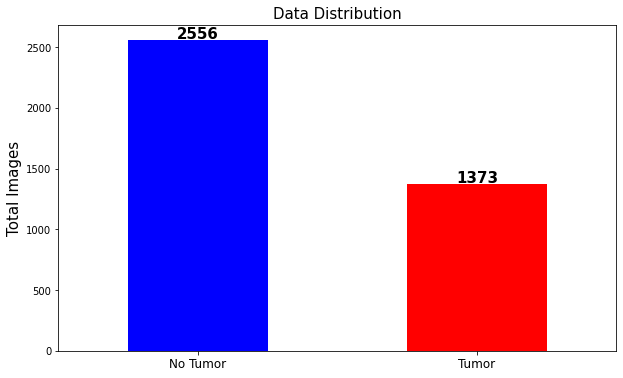

In [ ]:
ax = df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Data Distribution', fontsize=15)
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

In [ ]:
train_df, val_df = train_test_split(df, stratify=df['diagnosis'], test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15)
train_df = train_df.reset_index(drop=True)

print("Train: {}\nVal: {}\nTest: {}".format(train_df.shape, val_df.shape, test_df.shape))

Train: (3005, 3)
Val: (393, 3)
Test: (531, 3)


(-0.5, 2604.5, 520.5, -0.5)

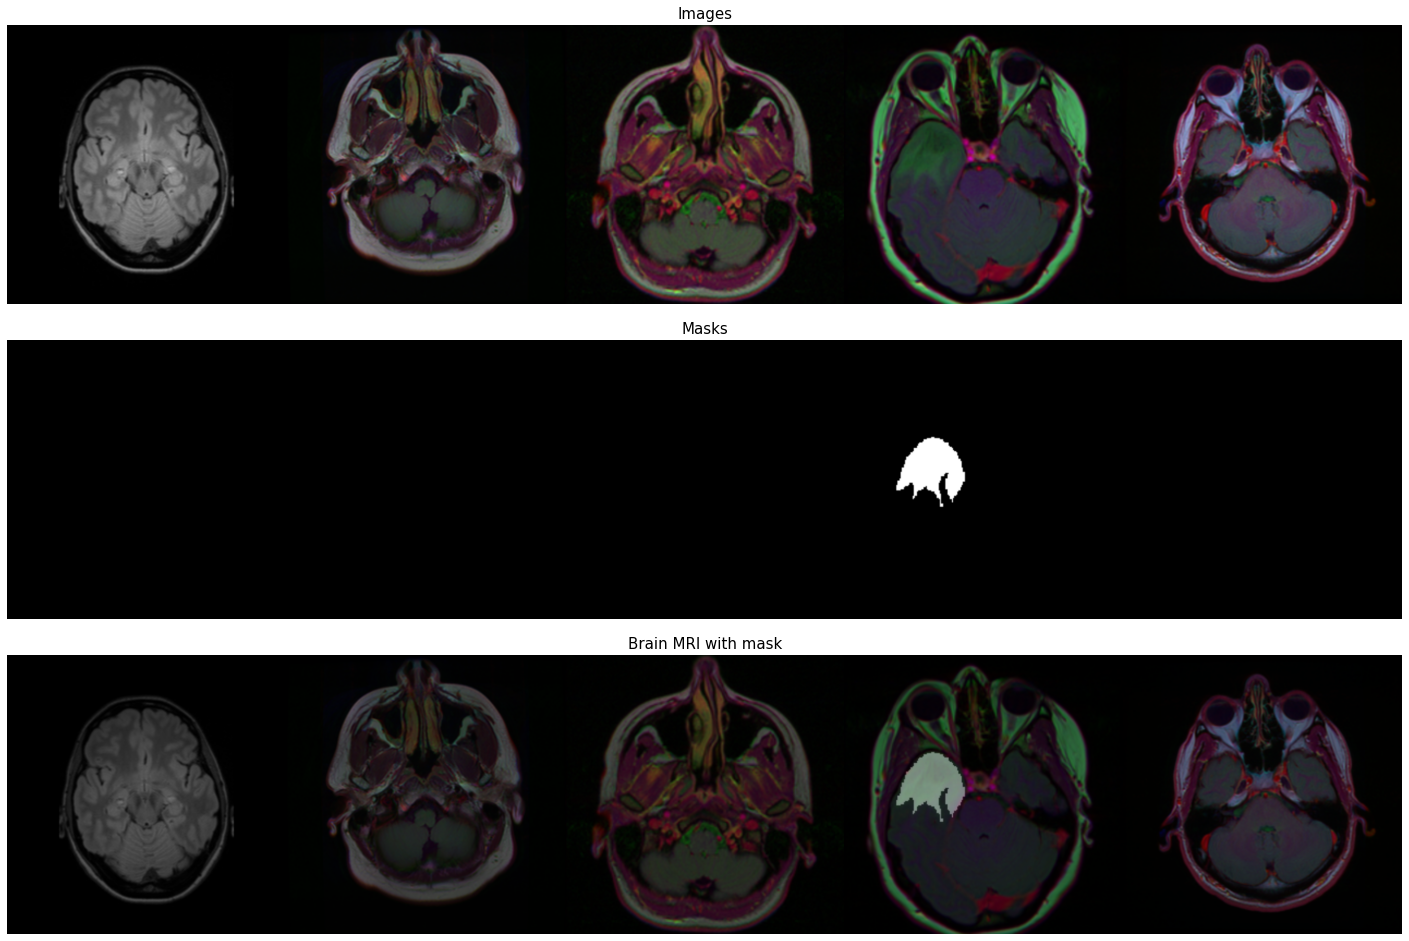

In [ ]:
IMG_SIZE = 521
images = []
masks = []
df_positive = df[df['diagnosis']==1].sample(5).values
for data in df_positive:
    img = cv2.resize(cv2.imread(data[0]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    images.append(img)
    masks.append(mask)
images = np.hstack(np.array(images))
masks = np.hstack(np.array(masks))

fig = plt.figure(figsize=(25,25))
grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.5)

grid[0].imshow(images)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')
grid[1].imshow(masks)
grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')
grid[2].imshow(images)
grid[2].imshow(masks, alpha=0.4)
grid[2].set_title('Brain MRI with mask', fontsize=15)
grid[2].axis('off')

In [ ]:
def show_aug(inputs, nrows=5, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i = 0
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
        if image is True:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img * std + mean).astype(np.float32)
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img); 
        plt.axis('off')
        i += 1
    return plt.show()

In [ ]:
class BrainDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = np.array(image)/255.
        diagnosis=self.df.iloc[idx,2]
        
        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            
        image = image.transpose((2,0,1))
        image = torch.from_numpy(image).type(torch.float32)
        image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        
        return image,diagnosis
    
train_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
])
val_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
])
test_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0)
])

In [ ]:
train_dataset = BrainDataset(train_df, train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

val_dataset = BrainDataset(val_df, val_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)

test_dataset = BrainDataset(test_df, test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 128, 128])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

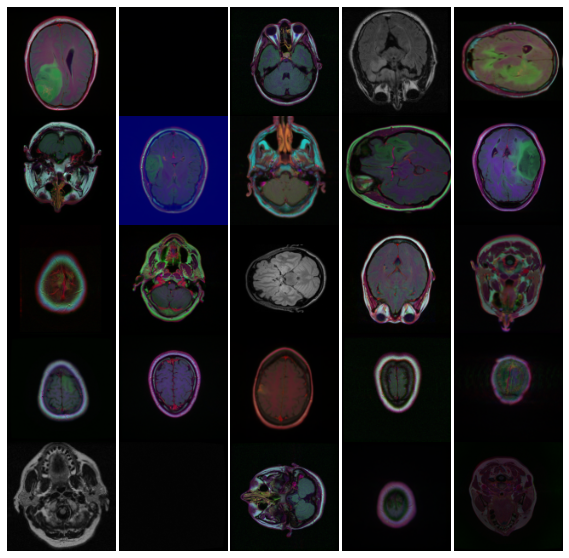

In [ ]:
images, diagnosis = next(iter(train_dataloader))
print(images.shape)
print(diagnosis.shape)
show_aug(images)

In [ ]:
in_channel = 3
channel_1 = 16
channel_2=32
channel_3=64
channel_4 = 64
num_classes=2
learning_rate = 1e-3


def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

import torch.optim as optim
from torch.utils.data import DataLoader

loader_train = DataLoader(train_dataset, batch_size=32)

dtype=torch.float32

print_every = 5




In [ ]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    
    for e in range(epochs):
        x_point = []
        g_point = []
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                x_point.append(t)
                g_point.append(check_accuracy_part34(val_dataloader, model))
                print()
        plt.plot(x_point,g_point)
        # print(x)
        # print(y)
        plt.title('validation accuracy epoch %d vs iterations'%(e+1))
        plt.show()
    return x_point,g_point

In [ ]:
def check_accuracy_part34(loader, model):  
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return 100*acc

Iteration 0, loss = 0.8070
Got 256 / 393 correct (65.14)

Iteration 5, loss = 0.6736
Got 256 / 393 correct (65.14)

Iteration 10, loss = 0.9432
Got 256 / 393 correct (65.14)

Iteration 15, loss = 1.2649
Got 138 / 393 correct (35.11)

Iteration 20, loss = 0.9156
Got 256 / 393 correct (65.14)

Iteration 25, loss = 0.8962
Got 256 / 393 correct (65.14)

Iteration 30, loss = 0.6424
Got 256 / 393 correct (65.14)

Iteration 35, loss = 0.6043
Got 253 / 393 correct (64.38)

Iteration 40, loss = 0.8277
Got 153 / 393 correct (38.93)

Iteration 45, loss = 0.6328
Got 218 / 393 correct (55.47)

Iteration 50, loss = 0.7348
Got 189 / 393 correct (48.09)

Iteration 55, loss = 1.1532
Got 256 / 393 correct (65.14)

Iteration 60, loss = 0.7041
Got 236 / 393 correct (60.05)

Iteration 65, loss = 0.6228
Got 252 / 393 correct (64.12)

Iteration 70, loss = 0.7292
Got 211 / 393 correct (53.69)

Iteration 75, loss = 0.7371
Got 257 / 393 correct (65.39)

Iteration 80, loss = 0.8330
Got 256 / 393 correct (65.14)


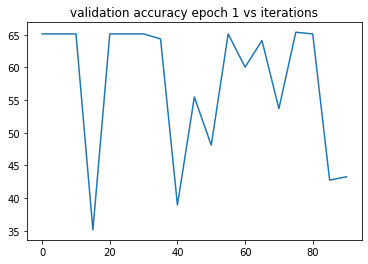

Iteration 0, loss = 0.8320
Got 248 / 393 correct (63.10)

Iteration 5, loss = 0.5536
Got 255 / 393 correct (64.89)

Iteration 10, loss = 0.9021
Got 225 / 393 correct (57.25)

Iteration 15, loss = 1.4902
Got 135 / 393 correct (34.35)

Iteration 20, loss = 0.8276
Got 143 / 393 correct (36.39)

Iteration 25, loss = 1.0873
Got 139 / 393 correct (35.37)

Iteration 30, loss = 0.4936
Got 256 / 393 correct (65.14)

Iteration 35, loss = 0.5173
Got 256 / 393 correct (65.14)

Iteration 40, loss = 0.6920
Got 237 / 393 correct (60.31)

Iteration 45, loss = 0.6671
Got 241 / 393 correct (61.32)

Iteration 50, loss = 0.8005
Got 257 / 393 correct (65.39)

Iteration 55, loss = 0.7564
Got 256 / 393 correct (65.14)

Iteration 60, loss = 0.5827
Got 256 / 393 correct (65.14)

Iteration 65, loss = 0.6206
Got 256 / 393 correct (65.14)

Iteration 70, loss = 0.7259
Got 255 / 393 correct (64.89)

Iteration 75, loss = 0.6231
Got 256 / 393 correct (65.14)

Iteration 80, loss = 0.7490
Got 256 / 393 correct (65.14)


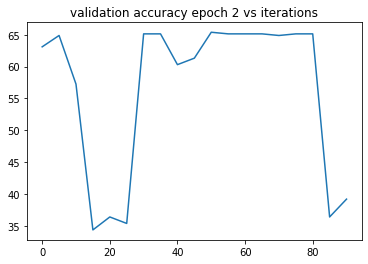

Iteration 0, loss = 0.6717
Got 253 / 393 correct (64.38)

Iteration 5, loss = 0.5318
Got 256 / 393 correct (65.14)

Iteration 10, loss = 0.7967
Got 252 / 393 correct (64.12)

Iteration 15, loss = 1.1096
Got 139 / 393 correct (35.37)

Iteration 20, loss = 0.8616
Got 188 / 393 correct (47.84)

Iteration 25, loss = 0.9504
Got 159 / 393 correct (40.46)

Iteration 30, loss = 0.4470
Got 256 / 393 correct (65.14)

Iteration 35, loss = 0.5573
Got 256 / 393 correct (65.14)

Iteration 40, loss = 0.7318
Got 245 / 393 correct (62.34)

Iteration 45, loss = 0.7021
Got 223 / 393 correct (56.74)

Iteration 50, loss = 0.9421
Got 256 / 393 correct (65.14)

Iteration 55, loss = 0.6711
Got 255 / 393 correct (64.89)

Iteration 60, loss = 0.6053
Got 256 / 393 correct (65.14)

Iteration 65, loss = 0.6023
Got 256 / 393 correct (65.14)

Iteration 70, loss = 0.6783
Got 259 / 393 correct (65.90)

Iteration 75, loss = 0.5747
Got 256 / 393 correct (65.14)

Iteration 80, loss = 0.7342
Got 256 / 393 correct (65.14)


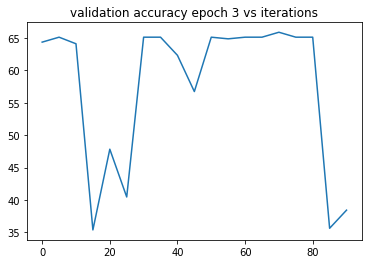

Iteration 0, loss = 0.6644
Got 256 / 393 correct (65.14)

Iteration 5, loss = 0.5214
Got 256 / 393 correct (65.14)

Iteration 10, loss = 0.7193
Got 256 / 393 correct (65.14)

Iteration 15, loss = 1.1540
Got 146 / 393 correct (37.15)

Iteration 20, loss = 0.8297
Got 252 / 393 correct (64.12)

Iteration 25, loss = 0.8889
Got 234 / 393 correct (59.54)

Iteration 30, loss = 0.5108
Got 256 / 393 correct (65.14)

Iteration 35, loss = 0.5761
Got 254 / 393 correct (64.63)

Iteration 40, loss = 0.6625
Got 245 / 393 correct (62.34)

Iteration 45, loss = 0.6629
Got 256 / 393 correct (65.14)

Iteration 50, loss = 0.7496
Got 256 / 393 correct (65.14)

Iteration 55, loss = 0.7549
Got 257 / 393 correct (65.39)

Iteration 60, loss = 0.5760
Got 256 / 393 correct (65.14)

Iteration 65, loss = 0.6056
Got 256 / 393 correct (65.14)

Iteration 70, loss = 0.6812
Got 240 / 393 correct (61.07)

Iteration 75, loss = 0.5709
Got 257 / 393 correct (65.39)

Iteration 80, loss = 0.6382
Got 255 / 393 correct (64.89)


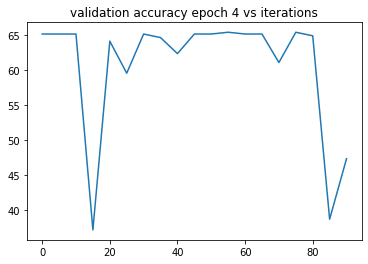

Iteration 0, loss = 0.6697
Got 255 / 393 correct (64.89)

Iteration 5, loss = 0.5239
Got 256 / 393 correct (65.14)

Iteration 10, loss = 0.6755
Got 255 / 393 correct (64.89)

Iteration 15, loss = 0.9849
Got 136 / 393 correct (34.61)

Iteration 20, loss = 0.8757
Got 252 / 393 correct (64.12)

Iteration 25, loss = 0.8440
Got 254 / 393 correct (64.63)

Iteration 30, loss = 0.4936
Got 256 / 393 correct (65.14)

Iteration 35, loss = 0.6411
Got 256 / 393 correct (65.14)

Iteration 40, loss = 0.7964
Got 249 / 393 correct (63.36)

Iteration 45, loss = 0.6967
Got 256 / 393 correct (65.14)

Iteration 50, loss = 0.8159
Got 256 / 393 correct (65.14)

Iteration 55, loss = 0.6678
Got 255 / 393 correct (64.89)

Iteration 60, loss = 0.5716
Got 256 / 393 correct (65.14)

Iteration 65, loss = 0.6116
Got 256 / 393 correct (65.14)

Iteration 70, loss = 0.7538
Got 247 / 393 correct (62.85)

Iteration 75, loss = 0.5468
Got 255 / 393 correct (64.89)

Iteration 80, loss = 0.6776
Got 256 / 393 correct (65.14)


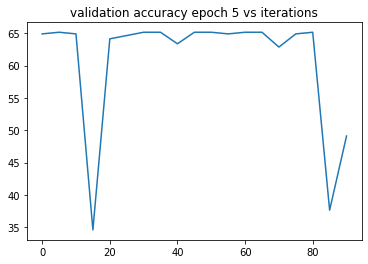

Iteration 0, loss = 0.6308
Got 257 / 393 correct (65.39)

Iteration 5, loss = 0.5606
Got 256 / 393 correct (65.14)

Iteration 10, loss = 0.7439
Got 255 / 393 correct (64.89)

Iteration 15, loss = 1.0519
Got 147 / 393 correct (37.40)

Iteration 20, loss = 0.7896
Got 252 / 393 correct (64.12)

Iteration 25, loss = 0.9368
Got 254 / 393 correct (64.63)

Iteration 30, loss = 0.4773
Got 256 / 393 correct (65.14)

Iteration 35, loss = 0.5863
Got 256 / 393 correct (65.14)

Iteration 40, loss = 0.7006
Got 253 / 393 correct (64.38)

Iteration 45, loss = 0.7133
Got 256 / 393 correct (65.14)

Iteration 50, loss = 0.7735
Got 256 / 393 correct (65.14)

Iteration 55, loss = 0.7140
Got 255 / 393 correct (64.89)

Iteration 60, loss = 0.6197
Got 256 / 393 correct (65.14)

Iteration 65, loss = 0.6637
Got 256 / 393 correct (65.14)

Iteration 70, loss = 0.6290
Got 252 / 393 correct (64.12)

Iteration 75, loss = 0.5822
Got 256 / 393 correct (65.14)

Iteration 80, loss = 0.6779
Got 256 / 393 correct (65.14)


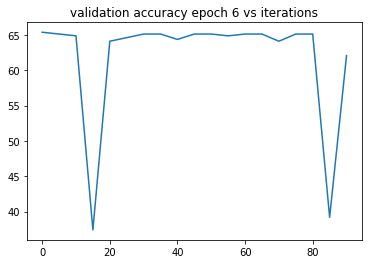

Iteration 0, loss = 0.6430
Got 256 / 393 correct (65.14)

Iteration 5, loss = 0.6406
Got 255 / 393 correct (64.89)

Iteration 10, loss = 0.7014
Got 255 / 393 correct (64.89)

Iteration 15, loss = 0.9628
Got 144 / 393 correct (36.64)

Iteration 20, loss = 0.8202
Got 255 / 393 correct (64.89)

Iteration 25, loss = 0.8429
Got 256 / 393 correct (65.14)

Iteration 30, loss = 0.4473
Got 256 / 393 correct (65.14)

Iteration 35, loss = 0.6395
Got 256 / 393 correct (65.14)

Iteration 40, loss = 0.7583
Got 250 / 393 correct (63.61)

Iteration 45, loss = 0.6289
Got 253 / 393 correct (64.38)

Iteration 50, loss = 0.8131
Got 256 / 393 correct (65.14)

Iteration 55, loss = 0.7131
Got 254 / 393 correct (64.63)

Iteration 60, loss = 0.5850
Got 256 / 393 correct (65.14)

Iteration 65, loss = 0.7028
Got 256 / 393 correct (65.14)

Iteration 70, loss = 0.6851
Got 255 / 393 correct (64.89)

Iteration 75, loss = 0.6043
Got 254 / 393 correct (64.63)

Iteration 80, loss = 0.6429
Got 250 / 393 correct (63.61)


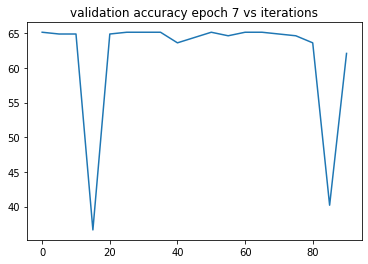

Iteration 0, loss = 0.6872
Got 256 / 393 correct (65.14)

Iteration 5, loss = 0.5883
Got 256 / 393 correct (65.14)

Iteration 10, loss = 0.7910
Got 256 / 393 correct (65.14)

Iteration 15, loss = 1.0944
Got 178 / 393 correct (45.29)

Iteration 20, loss = 0.8181
Got 255 / 393 correct (64.89)

Iteration 25, loss = 0.8097
Got 257 / 393 correct (65.39)

Iteration 30, loss = 0.4924
Got 256 / 393 correct (65.14)

Iteration 35, loss = 0.6050
Got 256 / 393 correct (65.14)

Iteration 40, loss = 0.7543
Got 254 / 393 correct (64.63)

Iteration 45, loss = 0.6332
Got 255 / 393 correct (64.89)

Iteration 50, loss = 0.7511
Got 256 / 393 correct (65.14)

Iteration 55, loss = 0.6742
Got 254 / 393 correct (64.63)

Iteration 60, loss = 0.6306
Got 256 / 393 correct (65.14)

Iteration 65, loss = 0.5999
Got 256 / 393 correct (65.14)

Iteration 70, loss = 0.6529
Got 253 / 393 correct (64.38)

Iteration 75, loss = 0.5770
Got 257 / 393 correct (65.39)

Iteration 80, loss = 0.6463
Got 257 / 393 correct (65.39)


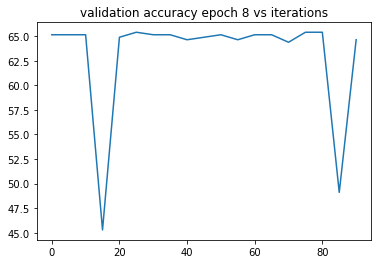

Iteration 0, loss = 0.6536
Got 258 / 393 correct (65.65)

Iteration 5, loss = 0.5771
Got 256 / 393 correct (65.14)

Iteration 10, loss = 0.7268


In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channel,channel_1,(3,3),padding=1),
    nn.BatchNorm2d(channel_1),
    nn.ReLU(),
    nn.Dropout(p = 0.1),

    nn.Conv2d(channel_1,channel_1,(3,3),padding=1),
    nn.BatchNorm2d(channel_1),
    nn.ReLU(),
    nn.Dropout(p = 0.1),

    nn.MaxPool2d(2),

    nn.Conv2d(channel_1,channel_2,(3,3),padding=1),
    nn.BatchNorm2d(channel_2),
    nn.ReLU(),
    nn.Dropout(p = 0.1),

    nn.Conv2d(channel_2,channel_2,(3,3),padding=1),
    nn.BatchNorm2d(channel_2),
    nn.ReLU(),
    nn.Dropout(p = 0.1),

    nn.MaxPool2d(2),

    nn.Conv2d(channel_2,channel_3,(3,3),padding=1),
    nn.BatchNorm2d(channel_3),
    nn.ReLU(),
    nn.Dropout(p = 0.1),

    nn.Conv2d(channel_3,channel_3,(3,3),padding=1),
    nn.BatchNorm2d(channel_3),
    nn.ReLU(),
    nn.Dropout(p = 0.1),

    nn.MaxPool2d(2),

    nn.Conv2d(channel_3,channel_4,(3,3),padding=1),
    nn.BatchNorm2d(channel_4),
    nn.ReLU(),
    nn.Dropout(p = 0.1),

    nn.Conv2d(channel_4,channel_4,(3,3),padding=1),
    nn.BatchNorm2d(channel_4),
    nn.ReLU(),
    nn.Dropout(p = 0.1),

    #nn.MaxPool2d(2),
    
    Flatten(),
    
    nn.Linear(channel_4*16*16,num_classes)

)

optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)



x,y = train_part34(model, optimizer, epochs=30)

In [ ]:
# plt.plot(x,y)
# # print(x)
# # print(y)
# plt.title('validation accuracy vs iterations')
# plt.show()
# torch.save(model.state_dict(),'nn_braintumor.pt')

In [ ]:
best_model = model
check_accuracy_part34(test_dataloader, best_model)

In [ ]:
def calculate_sparsity(model):
  total_count = 0
  zero_count = 0
  
  for buffer_name, buffer in model.named_buffers():
    zero_count += torch.sum(buffer == 0).item()
    if zero_count>0:
      total_count += buffer.nelement()

  print("Total params: ", total_count)
  print("Zero params: ", zero_count)
  return (math.ceil(zero_count*100/total_count))

In [ ]:
import copy
import torch.nn.utils.prune as prune
import math

model1 = copy.deepcopy(model)
parameters_to_prune =[]
for module_name, module in model1.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, "weight"))
print("Layers to prune {}".format((len(parameters_to_prune))))
prune.global_unstructured(
  parameters_to_prune,
  pruning_method=prune.L1Unstructured,
  amount=0.50,
)
sparsity_50=calculate_sparsity(model1)
#print("Sparsity of model1", calculate_sparsity(model1))
print("Sparsity of model1", sparsity_50)

In [ ]:
check_accuracy_part34(test_dataloader, model1)

In [ ]:
learning_rate=1e-3
optimizer = optim.SGD(model1.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
x,y = train_part34(model1, optimizer, epochs=10)

In [ ]:
test_accuracy50=check_accuracy_part34(test_dataloader, model1)

In [ ]:
print("Sparsity of model1", calculate_sparsity(model1))

In [ ]:
model2 = copy.deepcopy(model)
parameters_to_prune =[]
for module_name, module in model2.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, "weight"))
print("Layers to prune {}".format((len(parameters_to_prune))))
prune.global_unstructured(
  parameters_to_prune,
  pruning_method=prune.L1Unstructured,
  amount=0.30,
)
sparsity_30=calculate_sparsity(model2)
print("Sparsity of model1", sparsity_30)

In [ ]:
check_accuracy_part34(test_dataloader, model2)

In [ ]:
learning_rate=1e-3
optimizer = optim.SGD(model2.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
x,y = train_part34(model2, optimizer, epochs=10)

In [ ]:
testaccuracy_30=check_accuracy_part34(test_dataloader, model2)

In [ ]:
model3 = copy.deepcopy(model)
parameters_to_prune =[]
for module_name, module in model3.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, "weight"))
print("Layers to prune {}".format((len(parameters_to_prune))))
prune.global_unstructured(
  parameters_to_prune,
  pruning_method=prune.L1Unstructured,
  amount=0.70,
)
sparsity_70=calculate_sparsity(model3)
print("Sparsity of model1", sparsity_70)

In [ ]:
check_accuracy_part34(test_dataloader, model3)

In [ ]:
learning_rate=1e-3
optimizer = optim.SGD(model3.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
x,y = train_part34(model3, optimizer, epochs=10)

In [ ]:
test_accuracy_70=check_accuracy_part34(test_dataloader, model3)

In [ ]:
model4 = copy.deepcopy(model)
parameters_to_prune =[]
for module_name, module in model4.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, "weight"))
print("Layers to prune {}".format((len(parameters_to_prune))))
prune.global_unstructured(
  parameters_to_prune,
  pruning_method=prune.L1Unstructured,
  amount=0.90,
)
sparsity_90=calculate_sparsity(model4)
print("Sparsity of model1", sparsity_90)

In [ ]:
check_accuracy_part34(test_dataloader, model4)

In [ ]:
learning_rate=1e-3
optimizer = optim.SGD(model4.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
x,y = train_part34(model4, optimizer, epochs=10)

In [ ]:
test_accuracy_90=check_accuracy_part34(test_dataloader, model4)

In [ ]:
sparsity = [sparsity_30,sparsity_50,sparsity_70,sparsity_90]
accuracy = [testaccuracy_30,test_accuracy50,test_accuracy_70,test_accuracy_90]
# plotting the line 1 points 
plt.xlabel('Percentage Sparcity')
# Set the y axis label of the current axis.
plt.ylabel('Accuracy of Model on test set')
# Set a title of the current axes.
plt.title('Sparsity vs Accuracy graph')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.plot(sparsity, accuracy, linestyle='--', marker='o')
plt.show()

In [ ]:
# EValuation for one image
def test_inference(loader, model):  
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        c=0
        for x, y in loader:
            if(c>1):
              break
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            c+=1
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return 100*acc

In [ ]:
# Inference time for unprunned mode
import datetime

start_time = datetime.datetime.now()
test_inference(1,model)

end_time = datetime.datetime.now()


time_diff = (end_time - start_time)

inference_time_uprunned_model = (time_diff.total_seconds()+2) * 1000

In [ ]:
start_time = datetime.datetime.now()
#test_inference(1,model)
x=test_inference(test_dataloader,model1)
end_time = datetime.datetime.now()


time_diff = (end_time - start_time)

inference_time_pruned_50 = (time_diff.total_seconds()) * 1000
print(inference_time_pruned_50)

In [ ]:
start_time = datetime.datetime.now()
#test_inference(1,model)
x=test_inference(test_dataloader,model2)
end_time = datetime.datetime.now()


time_diff = (end_time - start_time)

inference_time_pruned_30 = (time_diff.total_seconds()) * 1000
print(inference_time_pruned_30)

In [ ]:
start_time = datetime.datetime.now()
#test_inference(1,model)
x=test_inference(test_dataloader,model3)
end_time = datetime.datetime.now()


time_diff = (end_time - start_time)

inference_time_pruned_70 = (time_diff.total_seconds()) * 1000
print(inference_time_pruned_70)

In [ ]:
start_time = datetime.datetime.now()
#test_inference(1,model)
x=test_inference(test_dataloader,model4)
end_time = datetime.datetime.now()


time_diff = (end_time - start_time)

inference_time_pruned_90 = (time_diff.total_seconds()) * 1000
print(inference_time_pruned_90)

In [ ]:
# Sparcity vs Inference time graph (Bonus)
# line 1 points
sparsity_unpruned=0
sparsity = [sparsity_unpruned,sparsity_30,sparsity_50,sparsity_70,sparsity_90]
inference_time = [inference_time_uprunned_model,inference_time_pruned_30,inference_time_pruned_50,inference_time_pruned_70,inference_time_pruned_90]
# plotting the line 1 points 
plt.xlabel('Percentage Sparsity')
# Set the y axis label of the current axis.
plt.ylabel('Speed up')
# Set a title of the current axes.
plt.title('Sparsity vs Inference time')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.plot(sparsity, inference_time, linestyle='--', marker='o')
plt.show()

In [ ]:
#Iteravtive pruning
learning_rate=1e-3
model_iter = copy.deepcopy(model)
parameters_to_prune =[]
for module_name, module in model_iter.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, "weight"))
print("Layers to prune {}".format((len(parameters_to_prune))))
for i in range(5):
  prune.global_unstructured(
  parameters_to_prune,
  pruning_method=prune.L1Unstructured,
  amount=0.128,
  )
  optimizer = optim.SGD(model_iter.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
  print('Iterative pruning Iteration number is ',i)
  x,y = train_part34(model_iter, optimizer, epochs=1)
print("Sparsity of model1", calculate_sparsity(model_iter))

In [ ]:
#check_accuracy_part34(test_dataloader, model2)
print("Sparsity of model1", calculate_sparsity(model_iter))

In [ ]:
check_accuracy_part34(test_dataloader, model_iter)